# Определение возраста покупателей

## Исследовательский анализ данных

Импортируем необходимый набор библиотек для исследовательского анализа.

In [6]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим данные.

In [11]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Всего имеем 7591 фото.

Посмотрим на структуру файла labels.csv

In [8]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


В одном столбец имя файла, в другом реальный возраст.

Построим гистограмму распределения возраста.

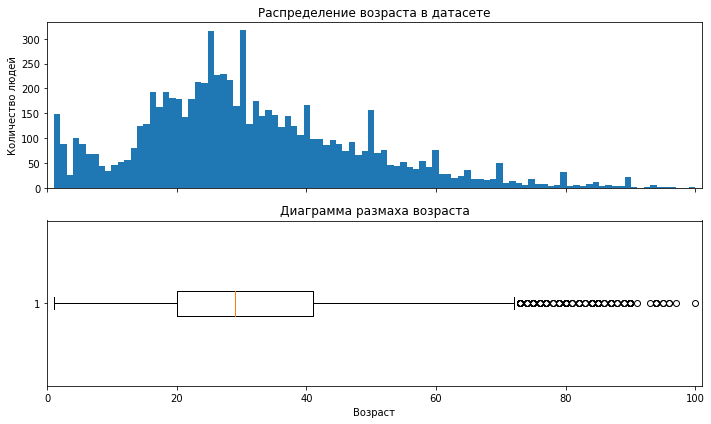

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 6))

ax1.hist(labels['real_age'], bins=100)
ax1.set_title('Распределение возраста в датасете')
ax1.set_ylabel('Количество людей')

ax2.boxplot(labels['real_age'], vert=False)  # vert=False - диаграмма размаха горизонтальная
ax2.set_title('Диаграмма размаха возраста')
ax2.set_xlabel('Возраст')

plt.xlim(labels['real_age'].min() - 1, labels['real_age'].max() + 1)  # Установка одинаковых пределов для обеих осей
plt.tight_layout()
plt.show()

Больше всего фото с возрастом человека в районе 20-30 лет. Меньше всего фото людей, кому за 70, что логично в силу среднего возраста по миру.

Посмотрим на пару фото в датасете.

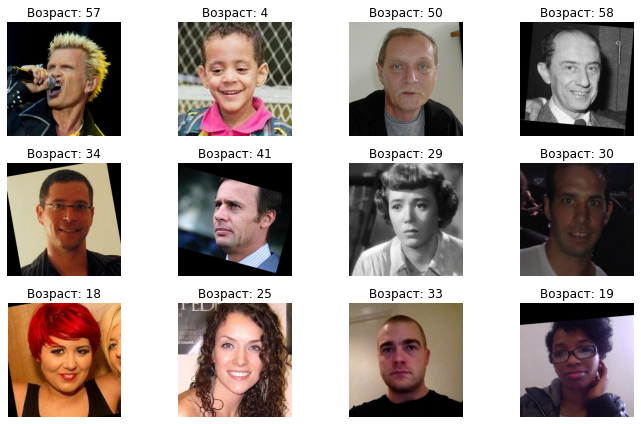

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 6))
for i, row in enumerate(labels.sample(n=12).iterrows()):
    image = Image.open('/datasets/faces/final_files/' + row[1]['file_name'])
    ax = axes[i // 4, i % 4]
    ax.imshow(image)
    ax.set_title(f'Возраст: {row[1]["real_age"]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

В целом по рандомной выборке все нормально, единственное что последнее фото некорректное, но это скорее всего проблема с фото в датасете.

**Вывод по исследовательской части:**
1. В нашем распоряжении 7591 фото.
2. Больше всего фото с возрастом человека в районе 20-30 лет, по обоим сторонам за этим диапазон примеров фото тоже достаточно. Скорее всего модель хорошо обучится предсказывать возраст по фото в этом диапазоне, ибо больше примеров для изучения. А вот возраст за 60 модель может плохо предсказать в силу малых примеров. 

## Обучение модели

```python

import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    df = pd.read_csv(f'{path}/labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, preprocessing_function=preprocess_input)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',  # Так как это регрессия
        subset='training',
        seed=12345
    )
    return train_datagen_flow

def load_test(path):
    df = pd.read_csv(f'{path}/labels.csv')
    
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25, preprocessing_function=preprocess_input)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        shuffle=False
    )
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet', 
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=0.0001)
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True)
    
    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/5
2024-10-06 13:00:58.585063: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-10-06 13:00:59.713894: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 75s - loss: 215.7913 - mae: 10.7683 - val_loss: 480.3501 - val_mae: 16.7382
Epoch 2/5
356/356 - 42s - loss: 64.4080 - mae: 6.1420 - val_loss: 157.3596 - val_mae: 9.4968
Epoch 3/5
356/356 - 42s - loss: 32.6606 - mae: 4.3952 - val_loss: 75.7459 - val_mae: 6.6152
Epoch 4/5
356/356 - 42s - loss: 18.2084 - mae: 3.2656 - val_loss: 75.1317 - val_mae: 6.5869
Epoch 5/5
356/356 - 44s - loss: 13.5423 - mae: 2.7871 - val_loss: 72.2578 - val_mae: 6.4612
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 13s - loss: 72.2578 - mae: 6.4612
Test MAE: 6.4612
```

## Анализ обученной модели

В качестве архитектуры для модели мы использовали предобученную модель ResNet50 со следующими параметрами:
```python
backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet', 
                        include_top=False)
```
После этого мы дополнили нашу модель следующими слоями:
```python
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
```
В качестве функции потерь мы указали MSE, а в качестве метрики MAE. При этом мы использовали оптимизатор Adam с шагом в 0.0001:
```python
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
```
Обучали мы нашу модель на 5 эпохах с размером батча 16.

В результате обучения модели мы получили метрику MAE на тестовой выборке в размере 6.4612, что довольно неплохо. Как говорилось, скорее всего модель сильнее ошибалась в том диапазоне возраста, где было мало примеров для обучения, то есть 60+ лет.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы